## CSCE 633
## Homework 1: Linear models

#### Due: 11:59pm on September 21, 2023

## Part A- Linear Regression

### Reading Data

In [33]:
# Question A
import pandas as pd

file_path = 'hw1_q1_data.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

In [34]:
df.head()

,name,stamina,attack_value,defense_value,capture_rate,flee_rate,spawn_chance,combat_point
0,Bulbasaur,90,126,126,0.16,0.10,69.0,1079
1,Ivysaur,120,156,158,0.08,0.07,4.2,1643
2,Venusaur,160,198,200,0.04,0.05,1.7,2598
3,Charmander,78,128,108,0.16,0.10,25.3,962
4,Charmeleon,116,160,140,0.08,0.07,1.2,1568


### (A-i) (5 points) Data exploration:

In [35]:
# Import required packages here
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scipy
import math

In [36]:
def get_pearson_coeff(feature1, feature2):
    '''
        given 2 feature names return the Pearson’s correlation coefficient between them
    '''
    pearson_coeff = scipy.stats.pearsonr(feature1, feature2)
    return pearson_coeff

def plot_scatter(feature1, feature2):
    '''
       Plot a 2D Scatter Plot between the 2 features, make sure to label the plots properly
    '''    
    pearson_coeff = get_pearson_coeff(feature1[1], feature2[1])
    plt.figtext(0,0,f"Pearson's Coeff: {round(pearson_coeff.statistic,2)}",fontsize = 10)
    plt.title(feature1[0]+" vs "+feature2[0])
    plt.scatter(feature1[1], feature2[1],alpha=0.5)
    plt.xlabel(feature1[0])
    plt.ylabel(feature2[0])
    plt.show()

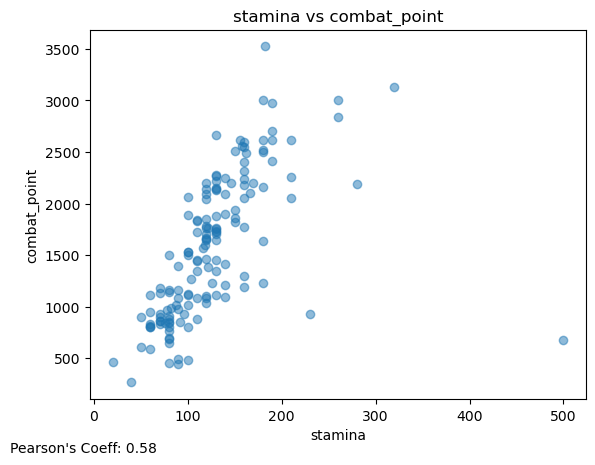

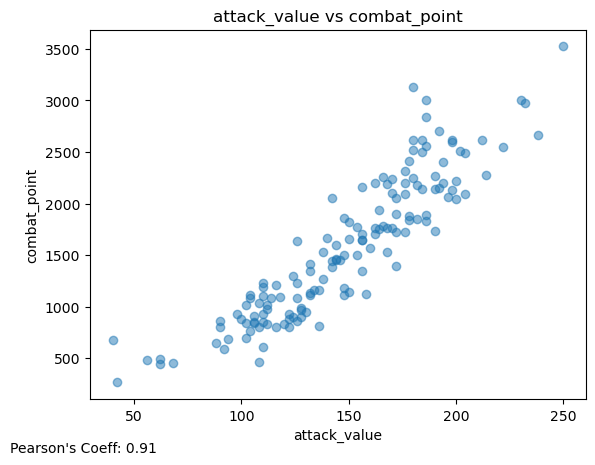

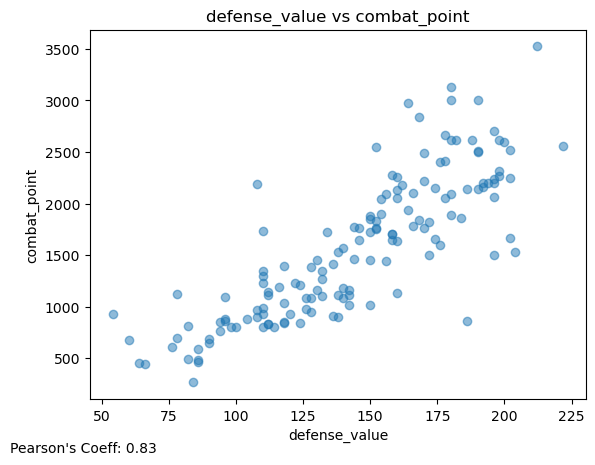

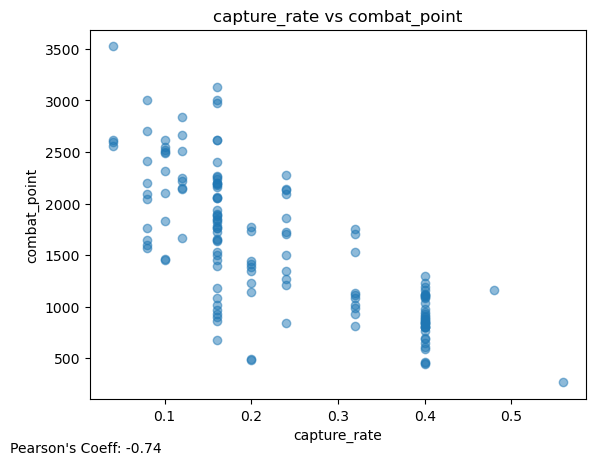

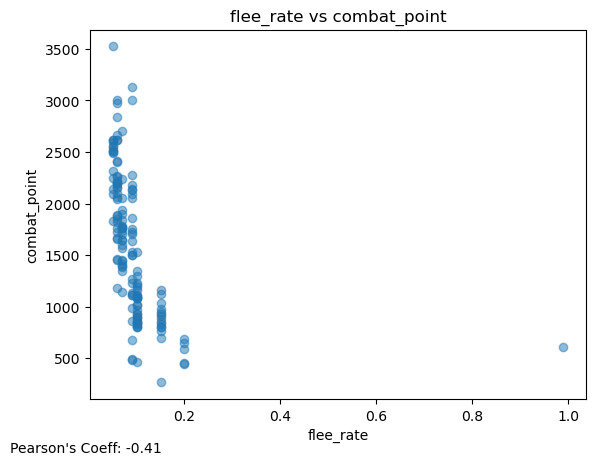

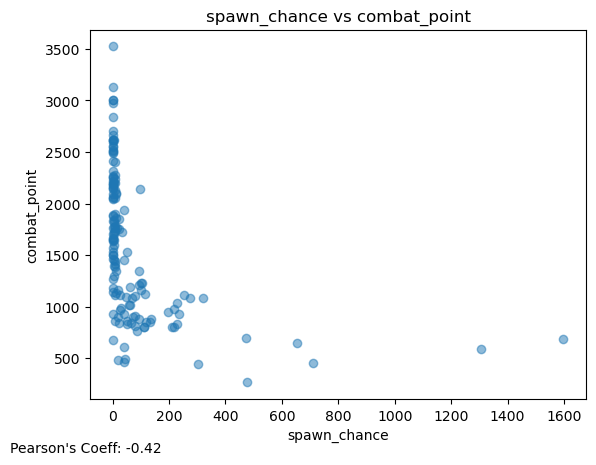

In [37]:
feature_list = df.iloc[:,1:7] # This list stores the features in the data 
coeff_list =  [] # This list stores the Pearson correlation coefficient

#Data Exploration, Scatter plots of features and output of interest(combat points)
for (i,feature) in enumerate(feature_list):
    correlation_coeff,_ = get_pearson_coeff(df[feature],df['combat_point'])
    plot_scatter((feature,df[feature]),('combat_point',df['combat_point']))
    coeff_list.append(round(correlation_coeff,2))

From the above scatter plots we can see that **attack_value** and **combat_point** are the most correlated, supported by the graph and the correlation coefficient which is equal to $\bf{0.91}$

**defense_value** and **combat_point** are also correlated closely with a pearson coefficient of **0.83**

Analysing above graphs we can say that **defense_value** and **attack_value** features are the most predictive of the number of combat points.
    

### (A-ii) (5 points) Data exploration:

,Feature1,Feature2,corr_coeff
0,stamina,attack_value,0.30
1,stamina,defense_value,0.30
2,stamina,capture_rate,-0.45
3,stamina,flee_rate,-0.27
4,stamina,spawn_chance,-0.28
5,attack_value,defense_value,0.74
6,attack_value,capture_rate,-0.69
7,attack_value,flee_rate,-0.37
8,attack_value,spawn_chance,-0.43
9,defense_value,capture_rate,-0.70


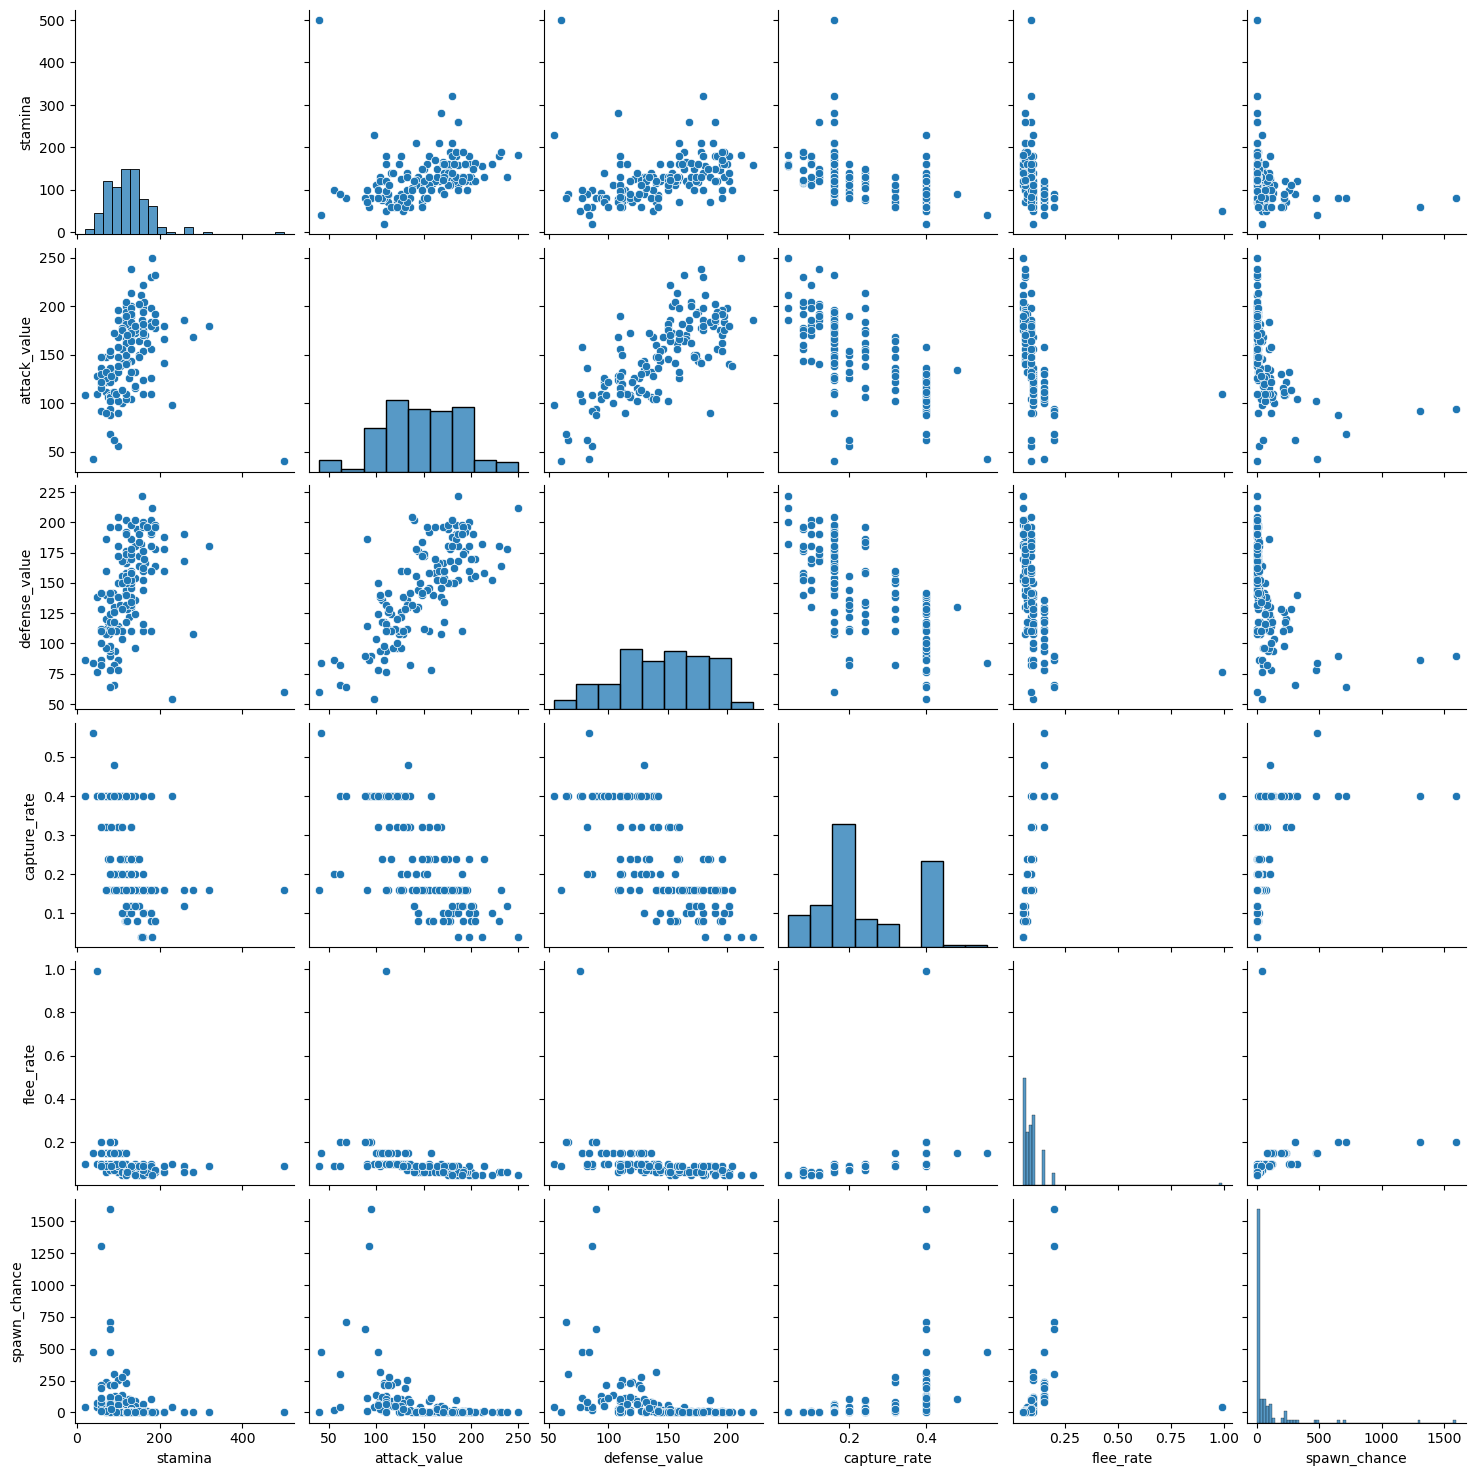

In [38]:
n = len(feature_list)
feature1_list = []
feature2_list = []
coeff_list = [] # This list stores the Pearson correlation values

feature_combinations = list(itertools.combinations(feature_list, 2))

for (feature1, feature2) in feature_combinations:
    feature1_list.append(feature1)
    feature2_list.append(feature2)
    correlation_coeff,_ = get_pearson_coeff(df[feature1], df[feature2])
    coeff_list.append(round(correlation_coeff,2))

sns.pairplot(feature_list)
data_exploration2_result = pd.DataFrame()
data_exploration2_result['Feature1'] = feature1_list
data_exploration2_result['Feature2'] = feature2_list
data_exploration2_result['corr_coeff'] = coeff_list
data_exploration2_result

From the above scatter plots between features, it is evident that **attack_value** and **defence_value** are the most correlated features out of all other combinations with a Pearson's coeffecient value of $\bf{0.74}$

### (A-iii) (15 points) Predicting combat points:

In [39]:
# Import required packages here
import numpy as np
import math
from scipy.stats import t


In [40]:
def get_predictions(X_train, y_train, X_test):
    '''
        This function is called in the cell below
        Given the train data, write code for training a linear regression model and
        return the predictions on given test data
    '''
    # Calculating weights or coeffectients using matrix multiplication
    X_train_transpose = np.transpose(X_train)
    w_coef = np.linalg.inv(X_train_transpose @ X_train) @ X_train_transpose @ y_train
    y_pred = X_test @ w_coef
    
    return y_pred


Calculating optimal weights/coeffecients for the linear regression models by minimising Residual Sum of Squares error:

$W* = (XX^T)^-1X^Ty$

$RSS = \sum \limits_{i=1}^N(y_i-\hat{y_i})^2$

In [41]:
#Model has only two parameters - Input and Target Variable
def linear_regression_model(df, selected_features, target_variable):
    '''
    Loop through the indices split and calculate the root mean squared error
    for each fold and append it to rss_scores list
    '''
    # This list stores rss values for each fold
    rss_sqrt_scores = []
    
    # Create the feature matrix X_train and target vector y_train
    X_train = df[selected_features].values
    y_train = df[target_variable].values
    
    num_folds = 5
    
    indices = np.arange(len(X_train))
    
    # Randomly shuffle the indices of the data
    np.random.shuffle(indices)
    
    # Split the data into n_folds subsets
    split_indices = np.array_split(indices, num_folds)
    
    #initialise the t_statistics_list and p_values_list
    t_statistics_list = []
    p_values_list = []
    
    # Loop through the indices split and calculate the square root of rss values
    for i in range(num_folds):
        # Define the indices for the current fold
        test_indices = np.sort(split_indices[i])
        
        #Hold out the indice i for testing and use all other indices for training the model
        train_indices = np.sort(np.concatenate([split_indices[j] for j in range(num_folds) if j != i]))

        # Split the data into train and test sets for the current fold
        X_fold_train, y_fold_train = X_train[train_indices], y_train[train_indices]
        X_fold_test, y_fold_test = X_train[test_indices], y_train[test_indices]
        
        #add Intercept column
        np.insert(X_fold_train,0,1,axis=1)
        np.insert(X_fold_test,0,1,axis=1)
        
        # Get predictions for the current fold
        y_fold_pred = get_predictions(X_fold_train, y_fold_train, X_fold_test)
        
        #calculate the residual sum of squares error
        rss = np.sum(np.square(y_fold_pred - y_fold_test))
        print("Square Root of RSS: ",math.sqrt(rss))
        rss_sqrt_scores.append(math.sqrt(rss))
        
        # Calculate t-statistics and p-values
        theta = np.linalg.inv(X_fold_train.T.dot(X_fold_train)).dot(X_fold_train.T).dot(y_fold_train)
        mean_standard_error = rss / (len(y_fold_train) - len(theta))
        var_theta = mean_standard_error * np.linalg.inv(X_fold_train.T.dot(X_fold_train))
        se_theta = np.sqrt(np.diagonal(var_theta)) #Standard Error (SE)
        t_statistics = theta / se_theta #t-statistics value
        
        degree_of_freedom = len(y_fold_train) - len(theta) #degree of freedom
        p_values = 2 * (1 - t.cdf(np.abs(t_statistics), degree_of_freedom)) #p values
        
        t_statistics_list.append(np.round(t_statistics))
        p_values_list.append(np.round(p_values))

    
#     # Print the RSS scores for each fold
    print("Square root of RSS Scores for each fold:", rss_sqrt_scores)
    print("--------------------------------------")
    print("Average Square root of RSS Score: ", np.mean(np.array(rss_sqrt_scores)))
    y_mean = np.mean(df['combat_point'].to_numpy())
    tss = np.sum(np.square(y_train - y_mean))
    average_rss = np.mean(rss_sqrt_scores)
    r_square = 1 - (average_rss**2/tss)
    print("R-Square Accuracy:",r_square)
    
    print()
    # Display t-statistics and p-values
    for fold, t_stats in enumerate(t_statistics_list, 1):
        print(f"Fold {fold} t-statistics for coefficients: {t_stats}")
        print(f"Fold {fold} p-values for coefficients: {p_values_list[fold-1]}")
        print("--------------------------------------")
        

# (A-iv) (15 points)

In [42]:
'''
  Experiment with different feature combinations and print the best avergae_rss
  Please provide the rationale behind selecting or dropping some features
'''
## Features: defense_value , attack_value , stamina, capture_rate, flee_rate
print("Features: [defense_value, attack_value, capture_rate, stamina, spawn_chance, flee_rate]")
selected_feature_list = ['defense_value','attack_value','capture_rate','stamina','spawn_chance','flee_rate'] #X
target_variable = "combat_point" #Y 
linear_regression_model(df, selected_feature_list, target_variable)
print()

## Features: defense_value , attack_value , stamina, capture_rate,
print("Features: [defense_value , attack_value, capture_rate, stamina]")
selected_feature_list = ['defense_value','attack_value','capture_rate','stamina'] #X
target_variable = "combat_point" #Y 
linear_regression_model(df, selected_feature_list, target_variable)
print()

## Features: attack_value, stamina_value , capture_rate, flee_rate
print("Features: [attack_value, capture_rate, stamina]")
selected_feature_list = ['attack_value','capture_rate','stamina'] #X
target_variable = "combat_point" #Y 
linear_regression_model(df, selected_feature_list, target_variable)

Features: [defense_value, attack_value, capture_rate, stamina, spawn_chance, flee_rate]
Square Root of RSS:  780.314759935482
Square Root of RSS:  3547.9833360801167
Square Root of RSS:  1111.4017479235465
Square Root of RSS:  925.9441678970005
Square Root of RSS:  1221.4121478071156
Square root of RSS Scores for each fold: [780.314759935482, 3547.9833360801167, 1111.4017479235465, 925.9441678970005, 1221.4121478071156]
--------------------------------------
Average Square root of RSS Score:  1517.4112319286521
R-Square Accuracy: 0.9666430874766437

Fold 1 t-statistics for coefficients: [ 10.  35. -25.  23.   3.  -3.]
Fold 1 p-values for coefficients: [0. 0. 0. 0. 0. 0.]
--------------------------------------
Fold 2 t-statistics for coefficients: [ 2.  6. -2.  7.  2. -2.]
Fold 2 p-values for coefficients: [0. 0. 0. 0. 0. 0.]
--------------------------------------
Fold 3 t-statistics for coefficients: [  7.  23. -17.  16.   2.  -2.]
Fold 3 p-values for coefficients: [0. 0. 0. 0. 0. 0.]


Question: Please provide the rationale behind selecting or dropping some features

There are three cases that are taken above to explain the feature selection:

**Case 1:**

**Feature Set:** Attack Value, Defense Value, Capture Rate, Stamina, Flee Rate, Spawn Chance

In this case, we see that Flee Rate and Spawn Chance have lower t-statistic value. It signifies that it does not have a high contribution to the predicted output. Hence we can drop them. Accuracy achieved by taking all features is **0.96**.

**Case 2:**

**Feature Set:** Attack Value, Defense Value, Capture Rate, Stamina

After dropping Flee Rate and Spawn Chance, the accuracy improved! However, we can also experiment by removing Defense value since it has a high correlation with Attack value which could have redundancy in feature space. Accuracy ahieved with this feature set is higher than case 1.

**Case 3:**

**Feature Set:** Attack Value, Defense Value, Capture Rate, Stamina

Dropping Defense value reduced the accuracy slightly. Hence, we can conclude that Case 2 feature set would be the best pick. 



### (A-v) (10 points)

Question: Explain the mathematical derivation for training the
linear regression model with ordinary least squares (OLS) solution.

---

To build and train a linear regression model using the Ordinary Least Squares (OLS) solution, we try to find the coefficients (weights) that minimize the sum of squared errors (SSE) between the predicted values and the actual target values. This is how the linear regression model is shown:

$y = w_0 + w_1x_1 + w_2x_2 + ... + w_px_p$

where,

- $y$ is the target variable.(The variable we want to predict
- $w_0$ is the bias term.
- $w_1, w_2, ... , w_p$ are the coeffecients/weights associated with each feature $x_1, x_2, x_3, ..., x_p$
- $p$ is the number of features.

The OLS solution finds the optimal values of coeffecients/weights which minimize the below loss function: 

$RSS =  \sum  \limits_{i=1}^N(y_i-\hat{y_i})^2$

$\hat{y_i} = w_0 + w_1x_{1i} + w_2x_{2i} + ... + w_px_{pi}$

where,
- $N$ is the number of data points in the dataset.
- $y_i$ is the actual target value.
- $x_{1i}, x_{2i},...,x_{pi}$ are the feature values for the $i^{th}$ data point.

To find the optimal coefficients we need to differentiate the loss function $RSS$ with respect to each $w_j (\ where,\ j = 0,1,...,p)$ and set the derivatives to zero. Solving these derivatives will give the optimal weights/coefficients minimizing the loss function. 

Below is the derivation for the same:

1. Partial derivative with respect to $w_0$ for $j=0,1,...,p$:
      $\frac{\partial{RSS}}{\partial{w_0}} = \sum\limits_{i=1}^N (y_i - (w_1x_{1i}+w_2x_{i2}+...+w_px_{pi}))(-1) = 0$
2. Partial derivative with respect to $w_j$:
      $\frac{\partial{RSS}}{\partial{w_j}} = \sum\limits_{i=1}^N (y_i - (w_1x_{1i}+w_2x_{i2}+...+w_px_{pi}))(-x_{ji}) = 0$

Solving the above set of equations will give the OLS estimates of the coefficients. They are usually represented in the form of matrix equations as shown below:

$ \begin{bmatrix}
    w_0 \\
    w_1 \\
    .   \\
    .   \\
    .   \\
    w_p
\end{bmatrix} = (XX^T)^-1X^Ty$

Where:

- $X$ is matrix containing feature values of all data points
- $X^T$ is the transpose of $X$ matrix
- $y$ is a vector of target values

Once we have obtained the values of coefficients, we can use them to make predictions for new data points using the linear regression model. The above solution is closed form solution. It provides the best values of $w_1, w_2, ..., w_p$ that minimize $RSS$.

# Part B - Logistic Regression

## (B-i) (20 points) Data Preprocessing

### 1. Download and read the data.
##### For Python, you may use pandas library and use read csv function

In [13]:
import pandas as pd
hitters_file_path = 'hw1_q2_data.csv'

df = pd.read_csv(hitters_file_path)



### 2. Print the data. How does the data look like? Add a short description about the data in the cell below.
#####  (You may use head() function in pandas library)

In [14]:
### YOUR CODE HERE
df.head()

,Player,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


Question: How does the data look like? Add a short description about the data.

This data is related to baseball player statistics, including both individual performance metrics and some demographic information. It has 21 columns which are the performance metrics of baseball players.

### 3. Print the shape of the data.
##### Shape means the dimensions of the data.


In [15]:
### YOUR CODE HERE
print("Dimension of data:",df.shape)
### YOUR CODE HERE

Dimension of data: (322, 21)


### 4. Does the data have any missing values? How many are missing? Print the number of missing values.
##### In pandas, check out isnul() and isnul().sum()


In [16]:
#Matrix representing the cells which having missing values
print("Missing value matrix")
print(df.isnull())
#Missing value count
print("Missing value count for each column")
df.isnull().sum()

Missing value matrix
     Player  AtBat   Hits  HmRun   Runs    RBI  Walks  Years  CAtBat  CHits  \
0     False  False  False  False  False  False  False  False   False  False   
1     False  False  False  False  False  False  False  False   False  False   
2     False  False  False  False  False  False  False  False   False  False   
3     False  False  False  False  False  False  False  False   False  False   
4     False  False  False  False  False  False  False  False   False  False   
..      ...    ...    ...    ...    ...    ...    ...    ...     ...    ...   
317   False  False  False  False  False  False  False  False   False  False   
318   False  False  False  False  False  False  False  False   False  False   
319   False  False  False  False  False  False  False  False   False  False   
320   False  False  False  False  False  False  False  False   False  False   
321   False  False  False  False  False  False  False  False   False  False   

     ...  CRuns   CRBI  CWalks

Player        0
AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

### 5. Drop all the rows with any missing data and print the shape of the data frame.
##### In pandas, check out dropna(). dropna() accepts an argument inplace, check out what it does and when it comes in handy.



In [17]:
df.dropna(inplace=True)
print("Dimension:",df.shape)
df.isnull().sum()

Dimension: (263, 21)


Player       0
AtBat        0
Hits         0
HmRun        0
Runs         0
RBI          0
Walks        0
Years        0
CAtBat       0
CHits        0
CHmRun       0
CRuns        0
CRBI         0
CWalks       0
League       0
Division     0
PutOuts      0
Assists      0
Errors       0
Salary       0
NewLeague    0
dtype: int64

### 6. Extract the features and the label from the data.
##### Our label is NewLeague and all the others are considered features.


In [18]:
features = df.drop(columns=['NewLeague','Player']) #X
labels = df['NewLeague'] #y

### 7. Data preprocessing. We want to do one-hot encoding for categorical features.
##### First separate numerical columns from nonnumerical columns.
##### Afterwards, use get dummies for transforming to categorical. Then concat both parts (pd.concat()).


In [19]:
non_numerical_features = features.select_dtypes(exclude=['int64','float64'])
numerical_features = features.select_dtypes(include=['int64','float64'])
encoded_features = pd.get_dummies(non_numerical_features, columns=non_numerical_features.columns)
processed_features = pd.concat([encoded_features, numerical_features],axis=1)
processed_features

,League_A,League_N,Division_E,Division_W,AtBat,Hits,HmRun,Runs,RBI,Walks,...,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
1,0,1,0,1,315,81,7,24,38,39,...,3449,835,69,321,414,375,632,43,10,475.0
2,1,0,0,1,479,130,18,66,72,76,...,1624,457,63,224,266,263,880,82,14,480.0
3,0,1,1,0,496,141,20,65,78,37,...,5628,1575,225,828,838,354,200,11,3,500.0
4,0,1,1,0,321,87,10,39,42,30,...,396,101,12,48,46,33,805,40,4,91.5
5,1,0,0,1,594,169,4,74,51,35,...,4408,1133,19,501,336,194,282,421,25,750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,0,1,1,0,497,127,7,65,48,37,...,2703,806,32,379,311,138,325,9,3,700.0
318,1,0,1,0,492,136,5,76,50,94,...,5511,1511,39,897,451,875,313,381,20,875.0
319,1,0,0,1,475,126,3,61,43,52,...,1700,433,7,217,93,146,37,113,7,385.0
320,1,0,1,0,573,144,9,85,60,78,...,3198,857,97,470,420,332,1314,131,12,960.0


### 8. Transform the output into numerical format.
##### If you have selected the label as a pandas series, you can use .replace() function. In the label, transform ’A’ to 0 and ’N’ to 1.


In [20]:
labels.replace('N',1,inplace=True)
labels.replace('A',0,inplace=True)
output = labels

## (B-ii) (20 points) Models for Hitters

### 1. Prediction: Using 80% of the data as a training set and 20% as a testing set.
#### You may use sklearn package in this question.


In [21]:
from sklearn.model_selection import train_test_split #import train_test_split library to split data into 80% training set and 20% testing set
from sklearn.linear_model import LinearRegression, LogisticRegression

In [22]:
#create an train models for linear and logistic regression
X_train, X_test, y_train, y_test = train_test_split(processed_features,output,test_size=0.2) #20% test set size 

#Linear Regression Model
model_linear_regression = LinearRegression()
model_linear_regression.fit(X_train,y_train)

#Logistic Regression Model
model_logistic_regression = LogisticRegression(max_iter = 150000)
model_logistic_regression.fit(X_train,y_train)

LogisticRegression(max_iter=150000)

### 2. Print the coefficients for each feature for both models. Are they the same? Are they different? Why? Please describe your observation in the cell below.

In [23]:
linear_coef   = model_linear_regression.coef_# to store the coefficients of the linear regression model
logistic_coef = model_logistic_regression.coef_# to store the coefficients of the logistic regression model
print(linear_coef)
print('\n')
print(logistic_coef)

[-4.36249957e-01  4.36249957e-01 -3.13503466e-03  3.13503466e-03
  9.54108980e-04 -1.27874753e-03 -1.43574474e-03 -1.55724536e-03
 -4.02886700e-04  6.37956433e-04 -1.32516362e-03 -1.29874184e-04
  9.38890069e-04  9.67096530e-04 -1.02282627e-03 -4.15906275e-04
  4.03736279e-04 -4.12701995e-06 -1.15553850e-04 -3.80309775e-03
 -1.30576321e-05]


[[-2.76899905e+00  2.41583674e+00 -2.67534773e-01 -8.56275336e-02
   1.36321173e-02 -2.61484278e-02 -3.85378390e-02 -2.63861679e-02
   7.37797647e-03  9.00438886e-03 -6.01123839e-02 -2.90607017e-03
   1.84925827e-02  1.63580013e-02 -1.45758778e-02 -8.84429562e-03
   6.56021896e-03  1.69306343e-04 -2.13607191e-03 -2.78624815e-02
  -1.91989488e-04]]


Question:  Are the coefficients for each feature for both models the same? Are they different? Why? Please describe

The coeffecients for each feature as evident in the above results are different. The reason is that the relationship between the features and the output variable is linear in case of linear regression, while logistic regression coefficients represent a relationship between the features and the likelyhood of binary target is logarithmic in nature due to the usage of sigmoid function as log functi"on. 

Linear Regression coefficients are continuous values, while logistic regression coefficients is not as straitforward to interpret as Linear Regression coefficients.

### 3. Plot the ROC curve for both models. Print the area under the curve measurements.


In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

### 4. What is the optimal decision threshold to maximize the f1 score? Print the optimal threshold.
### How did you calculate the optimal threshold? Explain in the cell below.


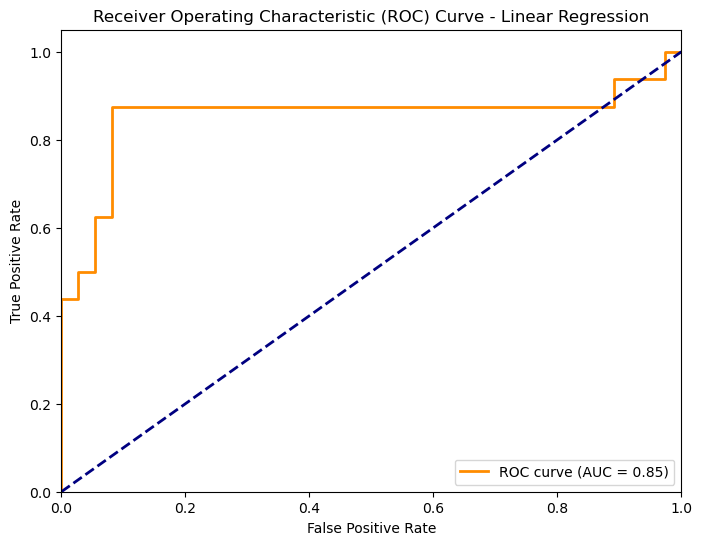

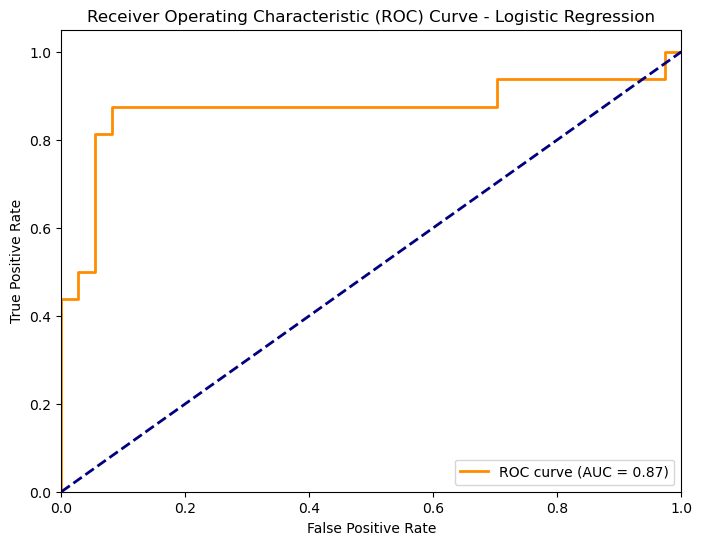

area under the curve for Linear Reg Model=  0.8547297297297297
area under the curve for Logistic Reg Model=  0.8716216216216216
Optimal Threshold for Linear Model=  0.8859679010557238
Optimal Threshold for Logistic Model=  0.8742635473881333


In [25]:
# Import required packages here
import numpy as np
from typing import Tuple, List

def linear_pred_and_area_under_curve(linear_model, x_test: np.ndarray, y_test: np.ndarray) -> Tuple[np.array, np.array, np.array, np.array, float]:
    '''
        return the tuple consisting the predictions and area under the curve measurements of Linear Regression
        Model in the following order
        [linear_reg_pred, linear_reg_fpr, linear_reg_tpr, linear_threshold, linear_reg_area_under_curve]
        Finally plot the ROC Curve
    '''
    linear_reg_pred = linear_model.predict(x_test)
    # Compute ROC curve
    linear_reg_fpr, linear_reg_tpr, linear_thresholds = roc_curve(y_test, linear_reg_pred)

    # Calculate the area under the ROC curve (AUC)
    linear_reg_area_under_curve = roc_auc_score(y_test, linear_reg_pred)

    # Create the ROC curve plot
    plt.figure(figsize=(8, 6))
    plt.plot(linear_reg_fpr, linear_reg_tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {linear_reg_area_under_curve:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - Linear Regression')
    plt.legend(loc='lower right')
    plt.show()
    
    return (linear_reg_pred, linear_reg_fpr, linear_reg_tpr, linear_thresholds, linear_reg_area_under_curve)


def logistic_pred_and_area_under_curve(logistic_model, x_test: np.ndarray, y_test: np.ndarray) -> Tuple[np.array, np.array, np.array, np.array, float]:
    '''
        return the tuple consisting the predictions and area under the curve measurements of
        Logistic Regression Model in the following order
        [log_reg_pred, log_reg_fpr, log_reg_tpr, log_threshold, log_reg_area_under_curve]
        Finally plot the ROC Curve
    '''
    log_reg_pred = logistic_model.predict_proba(x_test)[:, -1]
    # Compute ROC curve
    log_reg_fpr, log_reg_tpr, log_thresholds = roc_curve(y_test, log_reg_pred)

    # Calculate the area under the ROC curve (AUC)
    log_reg_area_under_curve = roc_auc_score(y_test, log_reg_pred)

    # Create the ROC curve plot
    plt.figure(figsize=(8, 6))
    plt.plot(log_reg_fpr, log_reg_tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {log_reg_area_under_curve:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
    plt.legend(loc='lower right')
    plt.show()
    return (log_reg_pred, log_reg_fpr, log_reg_tpr, log_thresholds, log_reg_area_under_curve)

linear_y_pred, linear_reg_fpr, linear_reg_tpr, linear_threshold, linear_reg_area_under_curve = linear_pred_and_area_under_curve(model_linear_regression, X_test, y_test)

log_y_pred, log_reg_fpr, log_reg_tpr, log_threshold, log_reg_area_under_curve = logistic_pred_and_area_under_curve(model_logistic_regression, X_test, y_test)


print('area under the curve for Linear Reg Model= ', linear_reg_area_under_curve )
print('area under the curve for Logistic Reg Model= ', log_reg_area_under_curve )

linear_optimal_threshold= -1
log_optimal_threshold= -1
'''
  Write code to determite the optimal threshold for linear and logistic regression
  and store them in linear_optimal_threshold and log_optimal_threshold
'''

#
max_f1_linear_score = 0
max_f1_log_score = 0

for threshold in linear_threshold:
   
    y_linear_test = (linear_y_pred > threshold).astype(int)
    f1_linear = f1_score(y_test, y_linear_test)
    
    
    # Update optimal threshold if a higher F1-score is found
    if f1_linear > max_f1_linear_score:
        max_f1_linear_score = f1_linear
        linear_optimal_threshold = threshold
        
for threshold in log_threshold:
    y_log_test = (log_y_pred > threshold).astype(int)
    f1_log = f1_score(y_test, y_log_test)
    
    if f1_log > max_f1_log_score:
        max_f1_log_score = f1_log
        log_optimal_threshold = threshold
        
print('Optimal Threshold for Linear Model= ', linear_optimal_threshold)
print('Optimal Threshold for Logistic Model= ', log_optimal_threshold)

Question: What is the optimal decision threshold to maximize the f1 score? How did you calculate the optimal threshold?

Ans: To find the optimal threshold, loop through the thresholds and check which threshold maximizes the f1 score and store that threshold as the optimal decision threshold.

The optimal decision threshold for Linear Reg Model is **0.88** 
The optimal decision threshold for Logistic Reg Model is **0.87** 

Note: Limit your answer to this cell

### 5. Five-fold Cross-validation: Repeat (1) using a stratified, five-fold cross-validation.


In [26]:
from sklearn.model_selection import StratifiedKFold

def train_test_folds(skf, num_of_folds: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, dict]:
    '''
        train and test in for loop with different training and test sets obatined from skf.
        use a PENALTY of 12 for logistic regression model for training
        find features in each fold and store them in features_count array.
        populate auc_log and auc_linear arrays with roc_auc_score of each set trained on logistic regression and linear regression models respectively.
        populate f1_log and f1_linear arrays with f1_score of each set trained on logistic regression and linear regression models respectively.
        return features_count, auc_log, auc_linear, f1_log and f1_linear
    '''
    num_of_folds = num_of_folds
    max_iter = 100000008

    X = processed_features
    y = output
    auc_log = []
    auc_linear = []
    features_count = []
    f1_log= []
    f1_linear= []
    for train_idx, test_idx in skf.split(X,y):
        train_X, test_X = X.iloc[train_idx], X.iloc[test_idx]
        train_y, test_y = y.iloc[train_idx], y.iloc[test_idx]
        
        #Train Logistic and Linear regression models, set a L2 penalty to avoid overfitting for logistic regression model
        logistic_reg_model = LogisticRegression(max_iter = 15000, penalty="l2")
        logistic_reg_model.fit(train_X,train_y)
        
        linear_reg_model = LinearRegression()
        linear_reg_model.fit(train_X, train_y)
        
        # Predict probabilities for logistic regression
        y_pred_prob_log = logistic_reg_model.predict_proba(test_X)[:, 1]
        
        # Predictions for linear regression (using 0.5 threshold for binary classification)
        y_pred_linear = (linear_reg_model.predict(test_X) > 0.5).astype(int)
        
        #append feature count 
        features_count.append(len(logistic_reg_model.coef_[0]))
        
        # Calculate ROC AUC for logistic regression
        auc_log.append(roc_auc_score(test_y, y_pred_prob_log))
        
        # Calculate F1 score for logistic regression
        f1_log.append(f1_score(test_y, (y_pred_prob_log > 0.5).astype(int)))
        
        # Calculate ROC AUC for Linear Regression
        auc_linear.append(roc_auc_score(test_y, y_pred_linear))
        
        # Calculate F1 score for Linear regression
        f1_linear.append(f1_score(test_y, y_pred_linear))
        
    return features_count, auc_log, auc_linear, f1_log, f1_linear


num_folds= 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state= 55)
features_count, auc_log, auc_linear, f1_log, f1_linear = train_test_folds(skf, num_folds)
print(features_count, auc_log, auc_linear, f1_log, f1_linear)

[21, 21, 21, 21, 21] [0.9271428571428572, 0.9242857142857142, 0.8836206896551724, 0.9047619047619048, 0.9107142857142858] [0.9421428571428572, 0.9442857142857143, 0.9202586206896552, 0.9226190476190476, 0.9285714285714286] [0.9387755102040817, 0.8979591836734694, 0.888888888888889, 0.875, 0.923076923076923] [0.9387755102040817, 0.9411764705882353, 0.9130434782608695, 0.9166666666666666, 0.923076923076923]


### 6. Does the feature count change in each fold? Please explain in the cell below.


In [27]:
def is_features_count_changed(features_count: np.array) -> bool:
    '''
       compare number of features in each fold (features_count array's each element)
       return false if features count doesn't change in each fold. else return true
    '''
    for i in range(len(features_count)-1):
        if (features_count[i] - features_count[i+1])!=0:
            return True
    
    return False
        
# call is_features_count_changed function and print true if features count changes in each fold. else print false
print(f"Is feature count changing? {is_features_count_changed(features_count)}")


Is feature count changing? False


Question: Do the features change in each fold? \
No, because in L2 Regularization it shrinks the weights close to 0 rather than actually reducing it to 0.

In [28]:
from scipy import stats
def mean_confidence_interval(data: np.array, confidence=0.95) -> Tuple[float, float, float]:
    '''
        The required interval is from mean-h to mean+h
        return the tuple consisting of mean, mean-h, mean+h
    '''
    mean_auc = np.mean(data) #calculate the mean of AUC
    
    confidence_interval = stats.t.interval(confidence, len(data) - 1, loc=mean_auc, scale=stats.sem(data)) # Calculate the confidence interval
    
    return mean_auc,confidence_interval[0],confidence_interval[1]


### 7. Please provide a mean and 95% confidence interval for the AUROCs for each model.

In [29]:
# Get the mean and confidence 
auc_linear_mean, auc_linear_open_interval, auc_linear_close_interval = mean_confidence_interval(auc_linear)
auc_log_mean, auc_log_open_interval, auc_log_close_interval = mean_confidence_interval(auc_log)

print('mean and 95% confidence interval for the AUROCs for linear model= '    ,(auc_linear_mean, auc_linear_open_interval, auc_linear_close_interval))
print('mean and 95% confidence interval for the AUROCs for logistic model= '  ,(auc_log_mean, auc_log_open_interval, auc_log_close_interval))

mean and 95% confidence interval for the AUROCs for linear model=  (0.9315755336617405, 0.9178253616558841, 0.9453257056675969)
mean and 95% confidence interval for the AUROCs for logistic model=  (0.9101050903119869, 0.8884050818200926, 0.9318050988038813)


### 8. Please provide a mean and 95% confidence interval for the f1 score for each model.

In [30]:
f1_linear_mean, f1_linear_open_interval, f1_linear_close_interval = mean_confidence_interval(f1_linear)
f1_log_mean, f1_log_open_interval, f1_log_close_interval = mean_confidence_interval(f1_log)

print('mean and 95% confidence interval for the f1 score for linear model= '  , (f1_linear_mean, f1_linear_open_interval, f1_linear_close_interval))
print('mean and 95% confidence interval for the f1 score for logistic model= '  , (f1_log_mean, f1_log_open_interval, f1_log_close_interval))

mean and 95% confidence interval for the f1 score for linear model=  (0.9265478097593552, 0.9106520203169857, 0.9424435992017248)
mean and 95% confidence interval for the f1 score for logistic model=  (0.9047401011686727, 0.8726222380967733, 0.936857964240572)


### (B-iii) (10 points)

### Explain the mathematical derivation you used for implementing the training of your linear and logistic regression models.
---
**Linear Regression:**
To build and train a linear regression model using the Ordinary Least Squares (OLS) solution, we try to find the coefficients (weights) that minimize the sum of squared errors (SSE) between the predicted values and the actual target values. This is how the linear regression model is shown:

$y = w_0 + w_1x_1 + w_2x_2 + ... + w_px_p$

where,

- $y$ is the target variable.(The variable we want to predict
- $w_0$ is the bias term.
- $w_1, w_2, ... , w_p$ are the coeffecients/weights associated with each feature $x_1, x_2, x_3, ..., x_p$
- $p$ is the number of features.

The OLS solution finds the optimal values of coeffecients/weights which minimize the below loss function: 

$RSS =  \sum  \limits_{i=1}^N(y_i-\hat{y_i})^2$

$\hat{y_i} = w_0 + w_1x_{1i} + w_2x_{2i} + ... + w_px_{pi}$

where,
- $N$ is the number of data points in the dataset.
- $y_i$ is the actual target value.
- $x_{1i}, x_{2i},...,x_{pi}$ are the feature values for the $i^{th}$ data point.

To find the optimal coefficients we need to differentiate the loss function $RSS$ with respect to each $w_j (\ where,\ j = 0,1,...,p)$ and set the derivatives to zero. Solving these derivatives will give the optimal weights/coefficients minimizing the loss function. 

Below is the derivation for the same:

1. Partial derivative with respect to $w_0$ for $j=0,1,...,p$:
      $\frac{\partial{RSS}}{\partial{w_0}} = \sum\limits_{i=1}^N (y_i - (w_1x_{1i}+w_2x_{i2}+...+w_px_{pi}))(-1) = 0$
2. Partial derivative with respect to $w_j$:
      $\frac{\partial{RSS}}{\partial{w_j}} = \sum\limits_{i=1}^N (y_i - (w_1x_{1i}+w_2x_{i2}+...+w_px_{pi}))(-x_{ji}) = 0$

Solving the above set of equations will give the OLS estimates of the coefficients. They are usually represented in the form of matrix equations as shown below:

$ \begin{bmatrix}
    w_0 \\
    w_1 \\
    .   \\
    .   \\
    .   \\
    w_p
\end{bmatrix} = (XX^T)^-1X^Ty$

Where:

- $X$ is matrix containing feature values of all data points
- $X^T$ is the transpose of $X$ matrix
- $y$ is a vector of target values

Once we have obtained the values of coefficients, we can use them to make predictions for new data points using the linear regression model. The above solution is closed form solution.

**Logistic Regression:**

Logistic Regression is used for binary classification. It models the probability that an instance belongs to a particular class. The most common model used for logistic regression is **Sigmoid**. It is defined below:

Model: 

$P(y = 1 | x) = \frac{1}{1+e^{-(w_0 + w_1x_{1} + w_2x_{2} + ... + w_px_{p})}}$
where,
* $P$ is the probability that instance $x$ belongs to class 1 which is a value range from 0 to 1
* The function used here is the sigmoid(logistic) function, $\sigma(z) = \frac{1}{1+e^{-z}}$
* The function maps a continous variable in real space $R$ to a closed set $[0,1]$
* This function adheres to the characteristics of probability function.

To understand how close the classifier output($\hat{y}$) is to the actual values $y$ we need a loss function $L$.

Here, $\hat{y}=\sigma(wx+b)$

$L(\hat{y},y)=$ How much does $\hat{y}$ differ from y.

We can use the cross-entropy loss function to do this. 

$P(y|x) = \hat{y}^{y}(1-\hat{y}^{1-y})$

when $y = 1$, $P(y|x) = \hat{y}$
when $y = 0$, $P(y|x) = 1 - y$

Taking log on both sides,

$log(P(y|x)) = ylog(\hat{y})+(1-y)log(1-\hat{y})$

The above equation is the log likelyhood equation which needs to be maximized. The cross-entropy loss function can be obtained by flipping the sign of log likelyhood.

$L_{CE} = -log(P(y|x)) = -ylog(\hat{y})-(1-y)log(1-\hat{y})$

we can now plug in the $\hat{y}=(wx+b)$,

$L_{CE} =-ylog(\sigma(wx+b))-(1-y)log(1-\sigma(wx+b))$

To find optimal weights during training, we make use of gradient descent, which is an iterative approach to find the optimal weights.

The idea is to iteratively update the coefficients $W$ in the direction of increasing log likelihood.